# Python example for Optimization

## PQMF Design
Take the frequency response of the baseband prototype or window function:$$H(\omega) = DTFT(h(n))$$Then we need to find (optimize) a function h(n), such that it fulfills:<br/>
1. **Attenuation**: The **stopband attenuation** should be high after the neighboring band to **minimize aliasing**:
    $$|H(\omega)|\approx 0 \quad for  \quad 1.5 \cdot \frac{\pi}{N}<|\omega|<\pi$$
2. **Unity condition**: Sum of magnitude squared frequency responses of $2$ **neighboring bands** should be close to to a **constant**, here $2N^2$, to achieve **near perfect reconstruction**: $$  |H(\omega)|^2 + |H(\omega+\pi/N)|^2 \approx 2 \cdot N^2 \quad for \quad 0\leqslant\omega<\frac{\pi}{N} $$

  To fulfill these requirements, we now have an **optimization problem**. Python has powerful optimization libraries to find a solution. Take a very simple example: **find the minimum** of the function of 2 variables, **$$f(x_1, x_2)=sin(x_1)+cos(x_2)$$** 
 
* In Python we write it as a function in file **functionexamp.py:**

### functionexamp

In [1]:
#function example with several unknowns (variables) for optimization
#Gerald Schuller, Nov. 2016
import numpy as np

def functionexamp(x):
    #x: array with 2 variables
    
    y=np.sin(x[0])+np.cos(x[1])
    return y

---

---

* Next we use the library scipy.optimize to find a minimum, and use its function “minimize”. We save it for instance as **optimizationExample.py**

### optimizationExample

In [2]:
#Optimization example, see also:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/optimize.html
#Gerald Schuller, Nov. 2016
#run it with "python optimizationExample.py" in a termina shell
#or type "ipython" in a termina shell and copy lines below:

import numpy as np
import scipy.optimize as optimize
from functionexamp import functionexamp

#Example for 2 unknowns, args: function-name, starting point, method:
from functionexamp import *
xmin = optimize.minimize(functionexamp, [-1.0, -3.0], method='CG')
print(xmin)

     fun: -1.0
     jac: array([  7.45058060e-09,   7.45058060e-09])
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 3
    njev: 8
  status: 0
 success: True
       x: array([ 0.21460184, -1.78539816])


And call it with ** *Python optimizationExample.py* **


**Observe**: We indeed obtain the minimium at $x_1=−π/2, x_2=−π$.

---

---

### PQMF Optimization, Python Example, Optimization Function 
### optimfuncQMF

In [3]:
import numpy as np
import scipy as sp
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline

def optimfuncQMF(x):
    """Optimization function for a PQMF Filterbank
    x: coefficients to optimize (first half of prototype h because of symmetry)
    err: resulting total error
    """
    N = 4 #4 subbands
    h = np.append(x, np.flipud(x))
    f, H_im = sig.freqz(h)
    H = np.abs(H_im) #only keeping the real part
    
    posfreq = np.square(H[0:512/N])
    
    #Negative frequencies are symmetric around 0:
    negfreq = np.flipud(np.square(H[0:512/N]))
    
    #Sum of magnitude squared frequency responses should be closed to unity (or N)
    unitycond = np.sum(np.abs(posfreq + negfreq - 2*(N*N)*np.ones(512/N)))/512
    
    #plt.plot(posfreq+negfreq)
    
    #High attenuation after the next subband:
    att = np.sum(np.abs(H[1.5*512/N:]))/512
    
    #Total (weighted) error:
    err = unitycond + 100*att
    return err

---

---

### PQMF Optimization, Python Example, Optimizer
> Now we have a function to minimize, and we can use Pythons powerful optimization library to minimize this function:


optimfuncQMF.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  att = np.sum(np.abs(H[1.5*512/N:]))/512


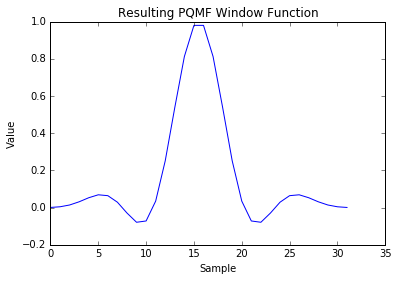

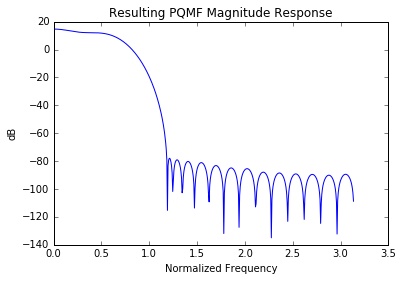

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.signal as sig
from optimfuncQMF import optimfuncQMF

#optimize for 16 filter coefficients:
xmin = opt.minimize(optimfuncQMF, 16*np.ones(16), method='SLSQP')
xmin = xmin["x"]

#Restore symmetric upper half of window:
h = np.concatenate((xmin, np.flipud(xmin)))
plt.plot(h)
plt.title('Resulting PQMF Window Function')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.show()

f, H = sig.freqz(h)
plt.plot(f, 20*np.log10(np.abs(H)))
plt.title('Resulting PQMF Magnitude Response')
plt.xlabel('Normalized Frequency')
plt.ylabel('dB')
plt.show()

**Observe**: We get almost 100 dB Stopband attenuation, much more than with the MDCT!

---

---

### PQMF Optimization, Python Example, Unity Condition

>We can test the PQMF Unity condition (slide 19) $$ |H(\omega)^2| + |H(\omega+\pi/N)^2|\approx2\cdot N^2\quad for \quad 0 \leq\omega<\frac{\pi}{N}$$ $(2N^2=32)$, with the following Python code

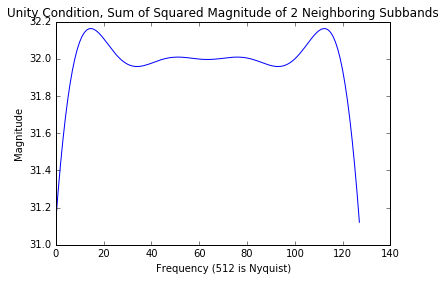

In [5]:
N = 4
f, H_im = sig.freqz(h)
posfreq = np.square(H[0:512/N])
negfreq = np.flipud(np.square(H[0:512/N]))
plt.plot((np.abs(posfreq) + np.abs(negfreq)))
plt.xlabel('Frequency (512 is Nyquist)')
plt.ylabel('Magnitude')
plt.title('Unity Condition, Sum of Squared Magnitude of 2 Neighboring Subbands')
plt.show()

**Observe:** 
  * We obtain a 4-band filter bank with filter length of 32 taps, hence 8 times overlap.
  * The stopband attenuation reaches almost 100 dB, almost right after the passband, much more than with the MDCT!